🔄 Lade vorhandenes Modell...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


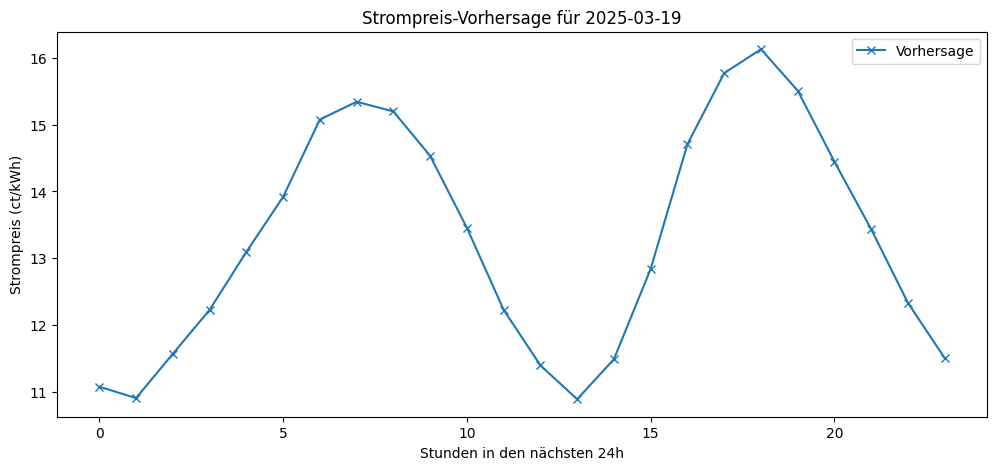

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from datetime import datetime, timedelta


file_path = "/Users/Andre/vscode-projects/BI-Steel-Project/machine_learning/energy_prices_data.csv"
model_path = "energy_price_model.h5"  

# load data
df = pd.read_csv(file_path, sep=';', decimal=',')
df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['von'], format='%d.%m.%Y %H:%M')
df = df[['Datetime', 'Spotmarktpreis in ct/kWh']]
df.rename(columns={'Spotmarktpreis in ct/kWh': 'Spotpreis'}, inplace=True)
df.set_index('Datetime', inplace=True)

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Spotpreis'] = scaler.fit_transform(df[['Spotpreis']])


def create_sequences(data, seq_length=336, output_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length - output_length):
        X.append(data[i:i + seq_length])  # 14 Tage Input
        y.append(data[i + seq_length:i + seq_length + output_length])  # 24 Stunden Output
    return np.array(X), np.array(y)


seq_length = 336  
output_length = 24  
data = df['Spotpreis'].values
X, y = create_sequences(data, seq_length, output_length)


X = X.reshape((X.shape[0], X.shape[1], 1))

# train test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


if os.path.exists(model_path):
    print("🔄 Lade vorhandenes Modell...")
    model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
else:
    print("🆕 Erstelle neues Modell...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50),
        Dense(output_length) 
    ])
    model.compile(optimizer='adam', loss='mse')

if not os.path.exists(model_path):  
    model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))
    model.save(model_path)  


latest_data = np.array([data[-seq_length:]])
latest_data = latest_data.reshape((1, seq_length, 1))
predictions = model.predict(latest_data)  


predictions = scaler.inverse_transform(predictions)


plt.figure(figsize=(12, 5))
plt.plot(predictions[0], label="Vorhersage", marker='x')
plt.xlabel("Stunden in den nächsten 24h")
plt.ylabel("Strompreis (ct/kWh)")
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")
plt.show()


In [ ]:

y_test = scaler.inverse_transform(y_test)


y_test = scaler.inverse_transform(y_test)




[[26.245 24.392 21.81  ... 19.974 13.993  5.249]
 [24.392 21.81  19.    ... 13.993  5.249  3.553]
 [21.81  19.    19.18  ...  5.249  3.553  0.107]
 ...
 [13.654 12.469 11.489 ... 16.124 15.886 14.396]
 [12.469 11.489 11.547 ... 15.886 14.396 13.294]
 [11.489 11.547 11.054 ... 14.396 13.294 12.743]]


In [ ]:
print(X_test[0])

[26.245 24.392 21.81  19.    19.18  22.215 22.539 33.535 40.907 42.186
 43.045 43.399 43.289 40.409 38.491 34.996 28.98  25.286 23.619 23.31
 21.155 19.974 13.993  5.249]
[[0.33119866]
 [0.32916155]
 [0.31794009]
 [0.30834755]
 [0.29523916]
 [0.29307497]
 [0.27752897]
 [0.29264752]
 [0.30386128]
 [0.31938802]
 [0.33100612]
 [0.32998564]
 [0.34080275]
 [0.33206126]
 [0.30257123]
 [0.29074133]
 [0.28388677]
 [0.28138755]
 [0.27815281]
 [0.27502975]
 [0.28259287]
 [0.28672102]
 [0.27287326]
 [0.25187827]
 [0.24067991]
 [0.23638618]
 [0.22695923]
 [0.22193769]
 [0.22694768]
 [0.22688221]
 [0.2430328 ]
 [0.28508054]
 [0.30230552]
 [0.32732468]
 [0.33227306]
 [0.33116015]
 [0.32864938]
 [0.30890593]
 [0.29654846]
 [0.28417558]
 [0.26920722]
 [0.26786711]
 [0.26401624]
 [0.26290333]
 [0.2605928 ]
 [0.26660017]
 [0.26381214]
 [0.25810899]
 [0.24191219]
 [0.23391392]
 [0.22839561]
 [0.2189417 ]
 [0.21789041]
 [0.22121757]
 [0.24021781]
 [0.26031554]
 [0.29758434]
 [0.31846766]
 [0.32351231]
 [0

In [25]:
print(model)

<Sequential name=sequential_2, built=True>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


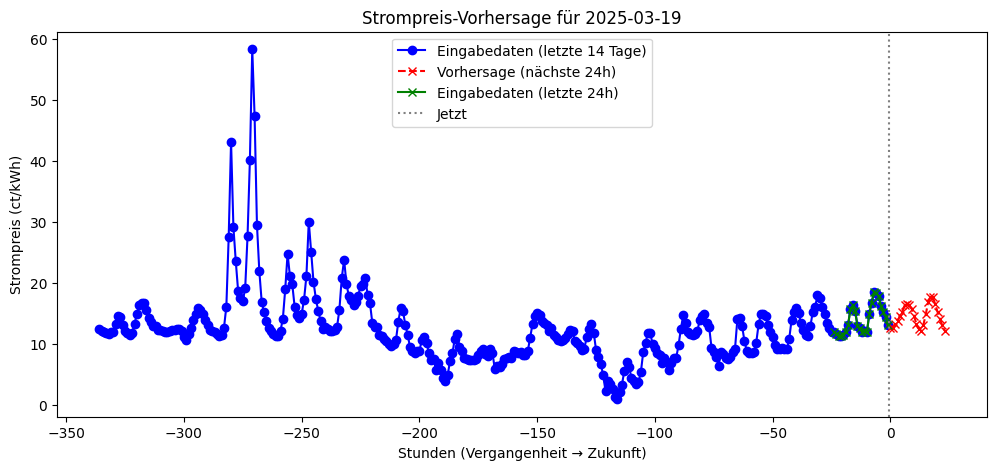

In [9]:
# Vorhersage mit den letzten 14 Tagen der Daten (336 Stunden)
latest_data = np.array([data[-seq_length:]])  # Nimm die letzten `seq_length` Werte der Daten
latest_data = latest_data.reshape((1, seq_length, 1))  # Reshaping für das LSTM-Modell

# Vorhersage der nächsten 24 Stunden
predictions = model.predict(latest_data)

# Rücktransformation der Vorhersagen in den Originalbereich
predictions = scaler.inverse_transform(predictions)

# Letzte 24 Stunden der Eingabedaten (zur Visualisierung)
input_last_24h = scaler.inverse_transform(data[-24:].reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(12, 5))

# Plot für die echten Daten der letzten 14 Tage (stundenweise)
plt.plot(range(-seq_length, 0), scaler.inverse_transform(data[-seq_length:].reshape(-1, 1)).flatten(), label="Eingabedaten (letzte 14 Tage)", marker='o', linestyle='-', color='blue')

# Plot für die Vorhersagen der nächsten 24 Stunden
plt.plot(range(0, output_length), predictions[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Plot der letzten 24 Stunden der Eingabedaten
plt.plot(range(-24, 0), input_last_24h, label="Eingabedaten (letzte 24h)", marker='x', linestyle='-', color='green')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden (Vergangenheit → Zukunft)")
plt.ylabel("Strompreis (ct/kWh)")
plt.axvline(x=-0.5, color='gray', linestyle='dotted', label="Jetzt")  # Trennlinie zwischen Vergangenheit und Zukunft
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")

# Plot anzeigen
plt.show()


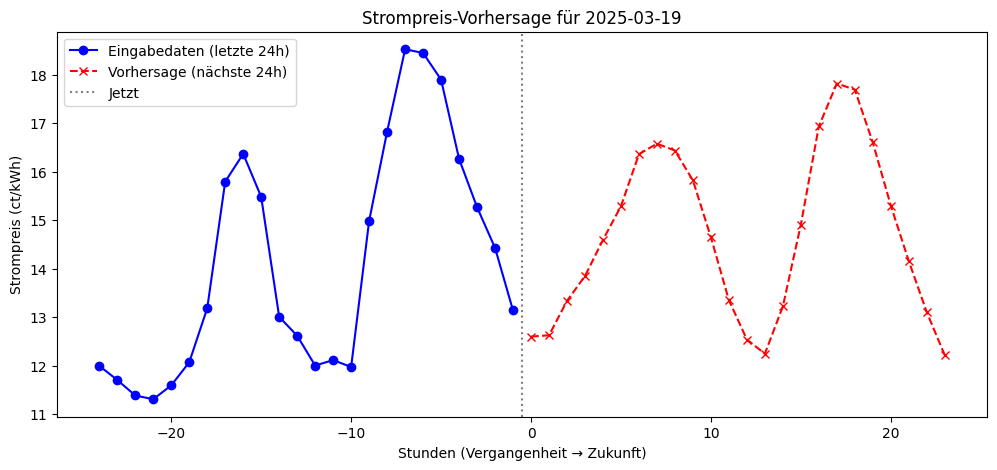

In [11]:
plt.figure(figsize=(12, 5))

# Letzte 24 Stunden aus den Input-Daten holen (zur Visualisierung)
input_last_24h = scaler.inverse_transform(data[-24:].reshape(-1, 1)).flatten()

# Plot für die echten Daten der letzten 24h
plt.plot(range(-24, 0), input_last_24h, label="Eingabedaten (letzte 24h)", marker='o', linestyle='-', color='blue')

# Plot für die Vorhersagen der nächsten 24h
plt.plot(range(0, 24), predictions[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden (Vergangenheit → Zukunft)")
plt.ylabel("Strompreis (ct/kWh)")
plt.axvline(x=-0.5, color='gray', linestyle='dotted', label="Jetzt")  # Trennlinie zwischen Vergangenheit/Zukunft
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")

plt.show()


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Vorhersage auf dem Testdatensatz
y_pred = model.predict(X_test)

# Rücktransformation der Vorhersagen und echten Werte
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Berechnung des Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inv, y_pred)

# Berechnung des Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Ausgabe der Metriken
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


715/715 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step
Mean Squared Error (MSE): 30.757024266186775
Root Mean Squared Error (RMSE): 5.545901573791837


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


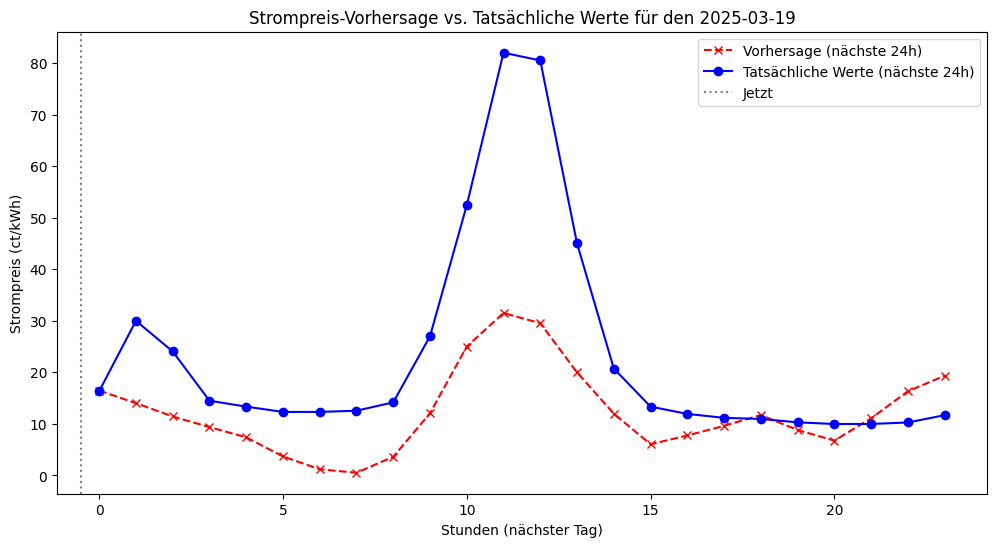

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Wählen eines zufälligen Index im Testdatensatz
random_index = np.random.randint(0, len(X_test))

# Hole die Eingabedaten und die tatsächlichen Ausgabewerte (y_test) für den zufälligen Index
input_data = X_test[random_index]
true_values = y_test[random_index]

# Mache eine Vorhersage für diesen Index
prediction = model.predict(input_data.reshape(1, seq_length, 1))

# Rücktransformation der Vorhersage und der tatsächlichen Werte
prediction = scaler.inverse_transform(prediction)
true_values = scaler.inverse_transform(true_values.reshape(1, -1))

# Plot der Vorhersage und der tatsächlichen Werte
plt.figure(figsize=(12, 6))

# Plot für die Vorhersage
plt.plot(range(24), prediction[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Plot für die tatsächlichen Werte
plt.plot(range(24), true_values[0], label="Tatsächliche Werte (nächste 24h)", marker='o', linestyle='-', color='blue')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden (nächster Tag)")
plt.ylabel("Strompreis (ct/kWh)")
plt.axvline(x=-0.5, color='gray', linestyle='dotted', label="Jetzt")  # Trennlinie zwischen Vergangenheit/Zukunft
plt.legend()
plt.title(f"Strompreis-Vorhersage vs. Tatsächliche Werte für zufälligen Tag")

# Anzeigen des Plots
plt.show()


In [13]:
df.describe()

,Spotpreis
count,114720.000000
mean,0.217176
std,0.028939
min,0.000000
25%,0.203873
50%,0.208325
75%,0.218364
max,1.000000
